In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.optimize import least_squares as lsq
import random
random.seed(4321)
np.random.seed(1234)

In [2]:
PolRel = pd.read_excel("Seshat_PolityRelationData.xlsx")
Data = pd.read_csv("Seshat Data.csv")
Parameters_and_Times = np.loadtxt("Parameters_and_Times.txt")
RelTimeDF = pd.read_csv("RelTime_TimeSeries_SPC1.csv", index_col = 0)
RelTimeCCDF = pd.read_csv("RelTime_TimeSeries_CC.csv")
Parameters = Parameters_and_Times[:4]
Times = Parameters_and_Times[4:]
T = 5000

In [3]:
def f(x, a, b, c, d):
    # the logistic function in its most general shape, scaled by T=5000
    return a / (1. + np.exp(-c * (x - d))) + b

In [4]:
del RelTimeCCDF["Unnamed: 0"]

In [5]:
set(Data["NGA"]).issubset(set(PolRel["NGA"]))

True

In [6]:
# Discard superfluous NGAs
SubsetNGA = np.array(PolRel["NGA"].isin(set(Data["NGA"])))
PolRel = PolRel.iloc[SubsetNGA]


In [7]:
PolRel.head(50)

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
13,Big Island Hawaii,Hawaii1,Hawaii I,1000.0,1200.0,n,General variables,succeeding (quasi)polity,Hawaii II,NaN,NaN,NaN
14,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,succeeding (quasi)polity,Hawaii III,NaN,NaN,NaN
15,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
16,Big Island Hawaii,Hawaii3,Hawaii III,1580.0,1778.0,n,General variables,succeeding (quasi)polity,Kingdom of Hawaii - Kamehameha Period,NaN,NaN,NaN
17,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,succeeding (quasi)polity,Cahokia - Middle Woodland,NaN,NaN,NaN
18,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
19,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,succeeding (quasi)polity,Cahokia - Late Woodland I,NaN,NaN,NaN
20,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN
21,Cahokia,USMisRo,Cahokia - Late Woodland I,300.0,450.0,n,General variables,succeeding (quasi)polity,Cahokia - Late Woodland II,NaN,NaN,NaN
22,Cahokia,USMisRo,Cahokia - Late Woodland I,300.0,450.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN


In [8]:
for i in list(set(PolRel["Dupl"])):
    print(i,sum(PolRel["Dupl"] == i))

y 103
n 596


In [9]:
# relationship to preceding (quasi)polity

for v in list(set(PolRel["Variable"])):
    print(v, sum(PolRel["Variable"]==v))

# Logical for Variable is the relationship
VR = PolRel["Variable"] == "relationship to preceding (quasi)polity"

Previous = PolRel.loc[np.logical_not(VR)]
Relationships = PolRel.loc[VR]

relationship to preceding (quasi)polity 335
succeeding (quasi)polity 364


In [10]:
Previous.head()

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
13,Big Island Hawaii,Hawaii1,Hawaii I,1000.0,1200.0,n,General variables,succeeding (quasi)polity,Hawaii II,NaN,NaN,NaN
14,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,succeeding (quasi)polity,Hawaii III,NaN,NaN,NaN
16,Big Island Hawaii,Hawaii3,Hawaii III,1580.0,1778.0,n,General variables,succeeding (quasi)polity,Kingdom of Hawaii - Kamehameha Period,NaN,NaN,NaN
17,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,succeeding (quasi)polity,Cahokia - Middle Woodland,NaN,NaN,NaN
19,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,succeeding (quasi)polity,Cahokia - Late Woodland I,NaN,NaN,NaN


In [11]:
Relationships.head()

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
15,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
18,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
20,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN
22,Cahokia,USMisRo,Cahokia - Late Woodland I,300.0,450.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN
23,Cahokia,USMisMu,Cahokia - Late Woodland II,450.0,600.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN


In [12]:
for val in list(set(Relationships["Value.From"])):
    print(val, sum(Relationships["Value.From"]==val) )
                

cultural assimilation 25
population migration 13
continuation 7
vassalage 1
not applicable 2
Continuity 9
continunity 4
continuity 228
Continuation 1
contination 1
elite migration 40
suspected unknown 2
replacement 1
indigenous revolt 1


In [13]:
# Ever

Relationships["Value.From"].replace("Continuation", "continuity", inplace = True)
Relationships["Value.From"].replace("continuation", "continuity", inplace = True)
Relationships["Value.From"].replace("continunity", "continuity", inplace = True)
Relationships["Value.From"].replace("contination", "continuity", inplace = True)
Relationships["Value.From"].replace("Continuity", "continuity", inplace = True)

                
for val in list(set(Relationships["Value.From"])):
    if val != "continuity":
        Relationships["Value.From"].replace(val, "discontinuity", inplace = True)

for val in list(set(Relationships["Value.From"])):
    print(val, sum(Relationships["Value.From"]==val) )    

continuity 250
discontinuity 85


C:\Users\Tobias\anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [14]:
CleanRel = pd.concat((Previous,Relationships), sort=False).sort_index()

In [15]:
CleanRel.head()

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
13,Big Island Hawaii,Hawaii1,Hawaii I,1000.0,1200.0,n,General variables,succeeding (quasi)polity,Hawaii II,NaN,NaN,NaN
14,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,succeeding (quasi)polity,Hawaii III,NaN,NaN,NaN
15,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
16,Big Island Hawaii,Hawaii3,Hawaii III,1580.0,1778.0,n,General variables,succeeding (quasi)polity,Kingdom of Hawaii - Kamehameha Period,NaN,NaN,NaN
17,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,succeeding (quasi)polity,Cahokia - Middle Woodland,NaN,NaN,NaN


In [16]:
TimeZero = pd.read_csv("TimeZero.csv")
TimeZero.head()

,Unnamed: 0,Konya Plain,Ghanaian Coast,Cuzco,Middle Yellow River Valley,Yemeni Coastal Plain,Deccan,Latium,Upper Egypt,Susiana,Iceland,Orkhon Valley,Sogdiana,Paris Basin,Niger Inland Delta,Cambodian Basin,Kachi Plain,Central Java,Kansai
0,T0,-2000,1800,1400,-1800,400,-300,-700,-3100,-3700,1300,500,-500,-200,1000,300,-2500,800,400


In [17]:

# Again Discard superfluous NGAs
SubsetNGA_2 = np.array(Relationships["NGA"].isin(set(TimeZero.columns)))
Relationships = Relationships.iloc[SubsetNGA_2]

set(Relationships["NGA"]).issubset( set(TimeZero.columns))


True

In [18]:
Relationships["Polity.End.Scaled"] = 0

# iterate over all rows in the DF
for i in range(Relationships.shape[0]):
    n = Relationships["NGA"].iloc[i]
    
    # for this NGA: read its Time_Zero from the TimeZero.csv
    T_zero = TimeZero[n]
    # Shift the time accordingly
    Relationships["Polity.End.Scaled"].iloc[i] = Relationships["Polity.End"].iloc[i] - T_zero
    

C:\Users\Tobias\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [19]:
from scipy.stats import gaussian_kde
KDE = gaussian_kde(Relationships["Polity.End.Scaled"])
time_range = np.arange(-6000,6000,10)
KDE_t = KDE(time_range)

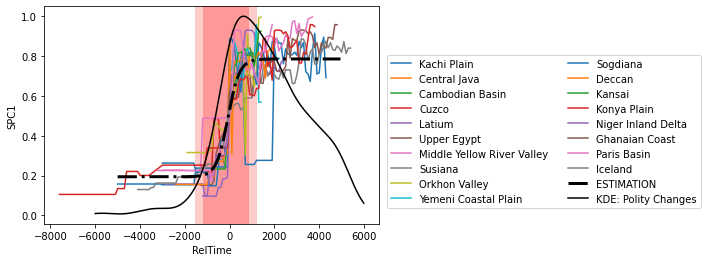

In [20]:
# Time Series Data fpr Reltime vs. SPC1
for N in list(set(RelTimeDF["NGA"])):
    DF = RelTimeDF[RelTimeDF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    
# Interpolation
x_show = np.arange(-1,1,0.01)    
y_hat = f(x_show, Parameters[0], Parameters[1], Parameters[2], Parameters[3])
plt.plot(x_show*T, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # scaled by T
plt.ylabel("SPC1")
plt.xlabel("RelTime")

# Denote the Regions of fast growth
plt.axvspan(Times[1], Times[2], facecolor='r', alpha=0.4)
plt.axvspan(Times[2], Times[3], facecolor='r', alpha=0.2)
plt.axvspan(Times[0], Times[1], facecolor='r', alpha=0.2)

# KDE of the polity changes
plt.plot(time_range, KDE_t / max(KDE_t), c="k", label="KDE: Polity Changes")

plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)


plt.show()

## Normalise the Number of Polity Changes

Divide it by the number of existing polities at RelTime T, because if there are only few polities at an early time, we would also only expect few possible polity changes.

In [21]:
T_min, T_max = min(RelTimeDF["RelTime"]), max(RelTimeDF["RelTime"])

In [22]:
NumberPol = pd.DataFrame(columns=["RelTime", "NumberPol"])
for t in np.arange(T_min, T_max+100, 100):
    #print(t)
    #print(sum(RelTimeDF["RelTime"]==t))
    NumberPol = pd.concat([NumberPol,
                         pd.DataFrame({"RelTime": [t],
                                      "NumberPol": [sum(RelTimeDF["RelTime"]==t)]})])
NumberPol

,RelTime,NumberPol
0,-7600,1
0,-7500,1
0,-7400,1
0,-7300,1
0,-7200,1
...,...,...
0,5000,1
0,5100,1
0,5200,1
0,5300,1


In [23]:
NumberPol["NumberPol"].loc[NumberPol["RelTime"]==1000]

0    13
Name: NumberPol, dtype: object

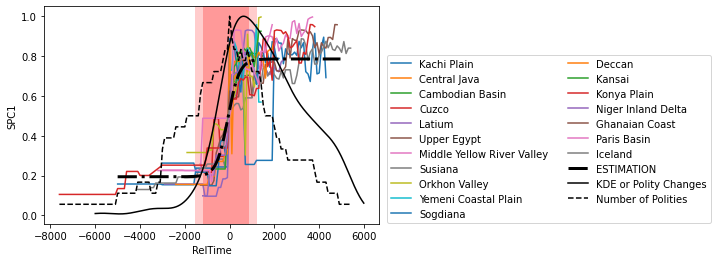

In [24]:
# Time Series Data fpr Reltime vs. SPC1
for N in list(set(RelTimeDF["NGA"])):
    DF = RelTimeDF[RelTimeDF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    
# Interpolation
x_show = np.arange(-1,1,0.01)    
y_hat = f(x_show, Parameters[0], Parameters[1], Parameters[2], Parameters[3])
plt.plot(x_show*T, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # scaled by T
plt.ylabel("SPC1")
plt.xlabel("RelTime")

# Denote the Regions of fast growth
plt.axvspan(Times[1], Times[2], facecolor='r', alpha=0.4)
plt.axvspan(Times[2], Times[3], facecolor='r', alpha=0.2)
plt.axvspan(Times[0], Times[1], facecolor='r', alpha=0.2)

# KDE of the polity changes
plt.plot(time_range, KDE_t / max(KDE_t), c="k", label="KDE or Polity Changes")

plt.plot(NumberPol["RelTime"], NumberPol["NumberPol"]/np.max(NumberPol["NumberPol"]), "--", c="k",
        label="Number of Polities")

plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)

plt.show()

## Deal with the Continuity of Polities

In [25]:
 # this DF tells is, if a polity in an NGA is continuous or not
print(Relationships)
print(sorted(list(set(Relationships["NGA"])))) # only the long-lived ones remain

                      NGA    PolID               Longform.Name  Polity.Start  \
42        Cambodian Basin  KhFunaE                     Funan I         225.0   
44        Cambodian Basin  KhFunaL                    Funan II         540.0   
46        Cambodian Basin  KhChenl                      Chenla         550.0   
49        Cambodian Basin  KhAngkE                Early Angkor         802.0   
51        Cambodian Basin  KhAngkC            Classical Angkor        1100.0   
..                    ...      ...                         ...           ...   
830           Upper Egypt  TrOttm3           Ottoman Empire II        1517.0   
834           Upper Egypt  TrOttm4          Ottoman Empire III        1683.0   
858  Yemeni Coastal Plain  YeQasmi     Yemen - Qasimid Dynasty        1637.0   
861  Yemeni Coastal Plain  TrOttm4          Ottoman Empire III        1683.0   
862  Yemeni Coastal Plain  YeOttoL  Ottoman Empire Late Period        1873.0   

     Polity.End Dupl            Section

In [26]:
print(Relationships[["NGA", "Polity.End.Scaled"]].loc[Relationships["Value.From"]=="discontinuity"].iloc[50:70])

             NGA  Polity.End.Scaled
580     Sogdiana              -50.0
587     Sogdiana              529.0
593     Sogdiana             1061.0
606     Sogdiana             1712.0
699      Susiana             1617.0
708      Susiana             2300.0
710      Susiana             2500.0
713      Susiana             2600.0
726      Susiana             3740.0
744      Susiana             4762.0
745      Susiana             4762.0
746      Susiana             4857.0
747      Susiana             4857.0
754      Susiana             5039.0
756      Susiana             5039.0
757      Susiana             5201.0
764      Susiana             5422.0
765      Susiana             5625.0
784  Upper Egypt             2353.0
788  Upper Egypt             2575.0


In [27]:
Breakpoints = Relationships[["NGA", "Polity.End.Scaled"]].loc[Relationships["Value.From"]=="discontinuity"]
Breakpoints.columns = ["NGA", "RelTime"]
Breakpoints.head()

,NGA,RelTime
67,Central Java,718.0
138,Cuzco,-751.0
142,Cuzco,-401.0
145,Cuzco,-150.0
149,Cuzco,132.0


In [28]:
# Get the snippet that includes RelTime=0 and does not have any discontinuity
def Cutout(nga, df = RelTimeDF):
    
    
    Output = df.loc[df["NGA"]==nga]
    
    # if the nga has a discontinuous breakpoint, we need to cut out the central part of Output around 0
    if nga in set(Breakpoints["NGA"]):
        
        # get this nga's breakpoints
        BPs = Breakpoints.loc[Breakpoints["NGA"] == nga]
        
        
        # isolate the first breakpoint above zero
        # NOT exactly zero, because a breakpoint at zero means that up to RelTime 0, the polity has changed
        BP_positive = BPs.loc[BPs["RelTime"] > 0]
        
        if BP_positive.shape[0]>0: # is there any Breakpoint after 0?
            BP_end = min(BP_positive["RelTime"])
        else:
            BP_end = np.infty # else: latest possible year
        
        # Now need the beginning of the cutout-area, i.e. the last breakpoint before BP_end
        BP_rest = BPs.loc[BPs["RelTime"] < BP_end]
        
        
        if BP_rest.shape[0] > 0: # is there even a breakpoint before this?
            BP_start = max(BP_rest["RelTime"])
        else:
            BP_start = -np.inf # else: set the earliest possible time as beginning for the cutout
    
        print("BPs",BPs)
        print(BP_start,BP_end)
        
        Output = Output.loc[Output["RelTime"] > BP_start-1 ]
        Output = Output.loc[Output["RelTime"] < BP_end +1 ]
        
    return(Output)

In [29]:
## Test
Cutout_DF = pd.DataFrame(columns = RelTimeDF.columns)
Cutout_CCDF = pd.DataFrame(columns = RelTimeCCDF.columns)

for n in list(set(RelTimeDF["NGA"])):
    print(Cutout(n))
    Cutout_DF = pd.concat((Cutout_DF, Cutout(n)))
    Cutout_CCDF = pd.concat((Cutout_CCDF, Cutout(n, RelTimeCCDF)))

BPs              NGA  RelTime
212  Kachi Plain  -3000.0
216  Kachi Plain   -700.0
230  Kachi Plain   2540.0
237  Kachi Plain   3061.0
-700.0 2540.0
             NGA  RelTime      SPC1
688  Kachi Plain     -700  0.242890
689  Kachi Plain     -600  0.242890
690  Kachi Plain     -500  0.242890
691  Kachi Plain     -400  0.242890
692  Kachi Plain     -300  0.242890
693  Kachi Plain     -200  0.242890
694  Kachi Plain     -100  0.242890
695  Kachi Plain        0  0.679867
696  Kachi Plain      100  0.679867
697  Kachi Plain      200  0.679867
698  Kachi Plain      300  0.679867
699  Kachi Plain      400  0.679867
700  Kachi Plain      500  0.679867
701  Kachi Plain      600  0.679867
702  Kachi Plain      700  0.255631
703  Kachi Plain      800  0.255631
704  Kachi Plain      900  0.255631
705  Kachi Plain     1000  0.255631
706  Kachi Plain     1100  0.255631
707  Kachi Plain     1200  0.276092
708  Kachi Plain     1300  0.276092
709  Kachi Plain     1400  0.276092
710  Kachi Plain     150

BPs           NGA  RelTime
579  Sogdiana    -21.0
580  Sogdiana    -50.0
587  Sogdiana    529.0
593  Sogdiana   1061.0
606  Sogdiana   1712.0
-21.0 529.0
          NGA  RelTime      SPC1
536  Sogdiana        0  0.887021
537  Sogdiana      100  0.884932
538  Sogdiana      200  0.854191
539  Sogdiana      300  0.765870
540  Sogdiana      400  0.684296
541  Sogdiana      500  0.619265
BPs           NGA  RelTime
579  Sogdiana    -21.0
580  Sogdiana    -50.0
587  Sogdiana    529.0
593  Sogdiana   1061.0
606  Sogdiana   1712.0
-21.0 529.0
BPs           NGA  RelTime
579  Sogdiana    -21.0
580  Sogdiana    -50.0
587  Sogdiana    529.0
593  Sogdiana   1061.0
606  Sogdiana   1712.0
-21.0 529.0
BPs         NGA  RelTime
166  Deccan   1273.0
173  Deccan   1627.0
174  Deccan   1946.0
-inf 1273.0
        NGA  RelTime      SPC1
212  Deccan    -2400  0.155157
213  Deccan    -2300  0.155157
214  Deccan    -2200  0.155157
215  Deccan    -2100  0.155157
216  Deccan    -2000  0.155157
217  Deccan    -1900 

In [30]:
Cutout_DF, Cutout_CCDF


(             NGA RelTime      SPC1
 688  Kachi Plain    -700  0.242890
 689  Kachi Plain    -600  0.242890
 690  Kachi Plain    -500  0.242890
 691  Kachi Plain    -400  0.242890
 692  Kachi Plain    -300  0.242890
 ..           ...     ...       ...
 593  Paris Basin     400  0.929827
 468      Iceland    -300  0.337468
 469      Iceland    -200  0.404175
 470      Iceland    -100  0.473478
 471      Iceland       0  0.528583
 
 [365 rows x 3 columns],
              NGA RelTime      SPC1    PolPop   PolTerr    CapPop    levels  \
 688  Kachi Plain    -700  0.242890  3.958214  2.395776  3.394593  2.152333   
 689  Kachi Plain    -600  0.242890  3.958214  2.395776  3.394593  2.152333   
 690  Kachi Plain    -500  0.242890  3.958214  2.395776  3.394593  2.152333   
 691  Kachi Plain    -400  0.242890  3.958214  2.395776  3.394593  2.152333   
 692  Kachi Plain    -300  0.242890  3.958214  2.395776  3.394593  2.152333   
 ..           ...     ...       ...       ...       ...       ...  

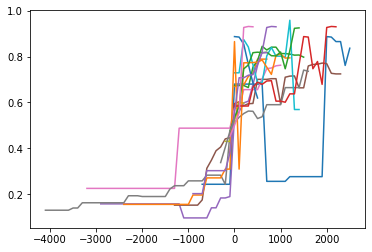

In [31]:
Cutout_DF
for n in list(set(Cutout_DF["NGA"])):
    smalldf = Cutout_DF.loc[Cutout_DF["NGA"]==n]
    #print(smalldf)
    plt.plot(smalldf["RelTime"], smalldf["SPC1"])
plt.show()

# Redo the RelTime Analysis with this Data?

## Fitting

In [32]:
X, y = Cutout_DF["RelTime"].to_numpy(), Cutout_DF["SPC1"].to_numpy()
T = 5000
X = np.array(list(X)) # for some reason, this transformation is necessary
X = X/T # normalisation of the data

def f(x, a, b, c, d):
    # the logistic function in its most general shape
    return a / (1. + np.exp(-c * (x - d))) + b

(a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, p0 = Parameters)

P0 = np.array((a_, b_, c_, d_))
print(P0)

[ 5.05526189e-01  2.04512960e-01  4.20835772e+01 -2.17749680e-02]


In [33]:
# comparison with full data:
Parameters

array([ 5.91641014e-01,  1.93784863e-01,  1.93749264e+01, -1.54321408e-02])

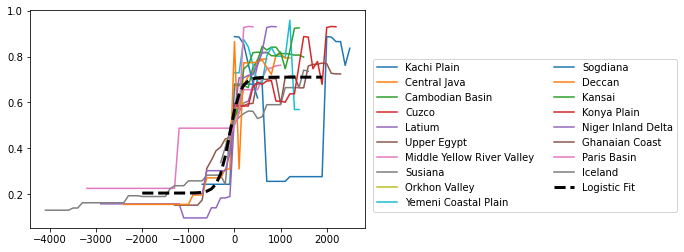

In [34]:
Cutout_DF
for n in list(set(Cutout_DF["NGA"])):
    smalldf = Cutout_DF.loc[Cutout_DF["NGA"]==n]
    #print(smalldf)
    plt.plot(smalldf["RelTime"], smalldf["SPC1"], label=n)

TimeRange = np.arange(-2000,2000,100)
New_Fit = f(TimeRange/T, a_, b_, c_, d_)
plt.plot(TimeRange, New_Fit, "--",label="Logistic Fit", c="k", linewidth = 3)
plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)
plt.show()

## Bootstrapping

In [35]:

nBT = 1000 # how many Bootstraps
negCcount = 0

Params = pd.DataFrame(columns = ["a", "b", "c", "d"]) # df of the parameters
NGA_list = list(set(Cutout_DF["NGA"]))


for i in range(nBT):
    NGA_selection = random.choices(NGA_list,k=len(NGA_list))
    Data_Bootstrap = pd.DataFrame(columns = Cutout_DF.columns)

    for n in NGA_selection:
        Data_Bootstrap = pd.concat([Data_Bootstrap, Cutout_DF[Cutout_DF["NGA"]==n]])
    
    
    X, y = Data_Bootstrap["RelTime"].to_numpy(), Data_Bootstrap["SPC1"].to_numpy()

    X = np.array(list(X)) # for some reason, this transformation is necessary
    X = X/T # normalisation of the data
    (a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, P0) # p0: Initial guess = Full Estimation
                                                     # Otherwise: direction can reverse with c<0

    Params = pd.concat([Params,
                       pd.DataFrame(data={"a":[a_], "b":[b_], "c":[c_], "d":[d_]})])
    if c_ < 0:
        print(NGA_selection)
        negCcount +=1
        for N in NGA_selection:
            DF = Data_RT[Data_RT["NGA"] == N]
            plt.plot(DF["RelTime"]/T,    # ALSO normalised
            DF["SPC1"], label=N)
            plt.plot(x_show, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # FOR FULL DATA
            plt.plot(x_show, f(x_show, a_, b_, c_, d_), "-.",c="r", linewidth = 3)

        plt.show()
        
    print(a_, b_, c_, d_)
    print("-----------------")
print(Params.round(2))

0.4516858099135281 0.20554983664498624 64.68023210767434 -0.02074788139307166
-----------------
0.5288544347547447 0.18962593214060341 75.97178963545593 -0.013274178952762127
-----------------
0.5035598731718973 0.19586774723313508 41.401635195300756 -0.02130625105208028
-----------------
0.43943489772612604 0.2486478971116142 107.54188346356537 -0.014972293122834475
-----------------
0.5337311507540314 0.1721766234092168 30.54253402354458 -0.02756350791761738
-----------------
0.5152321771065946 0.17195751141374382 50.85014802487617 -0.0194509431190789
-----------------
0.5800220416731775 0.19379984079104093 31.203908658691848 -0.016789900879537675
-----------------
0.5062420399282733 0.20862836364233123 28.214603605918416 -0.03375816192090925
-----------------
0.46286783071504856 0.18720618916914994 70.59627120696855 -0.020291539494152213
-----------------
0.5327101984086542 0.1805742942870422 58.3052905999979 -0.015597678871279622
-----------------
0.5431418872052193 0.1734273015531

0.4461724941460736 0.23384747349380489 760.5792864493835 -0.018684179468928527
-----------------
0.5780746470206072 0.1815681667332008 24.036948935055637 -0.018054397536387504
-----------------
0.5808962471493522 0.19353301799734335 23.906221527178822 -0.021380395911647643
-----------------
0.5846201300670215 0.18175583789732053 29.172036495862905 -0.03230423517074373
-----------------
0.4909156014765037 0.2033420979214576 41.28609384504831 -0.020964849890445864
-----------------
0.551399467444868 0.17303928128824966 40.17894128728681 -0.015212113773493545
-----------------
0.5808133580784975 0.1912579307297132 27.43061657608383 -0.017645717242426237
-----------------
0.49583550758207345 0.21505447773455344 20.85499696636743 -0.04122153651220082
-----------------
0.597205666695885 0.20626533756062418 14.433680081922088 -0.025660275275862506
-----------------
0.5436140393740825 0.2248594751815883 19.758746192924033 -0.03517633177203687
-----------------
0.5339905830721876 0.177617792443

0.5176742540667874 0.22762605787450033 53.12592146860739 -0.022553273271817047
-----------------
0.5449269597051098 0.22928268080652037 17.4159897312772 -0.03822393562397755
-----------------
0.5098218180424774 0.2160052188516811 50.2586232069507 -0.017907653469903796
-----------------
0.5131271553934117 0.19020286019863808 56.036151912209505 -0.023738034945275304
-----------------
0.5694097731522012 0.17516523838456916 25.782284674896996 -0.02899598716396183
-----------------
0.5466192279872496 0.18186563282384768 55.76777937310583 -0.01858678967789833
-----------------
0.550754000261381 0.20308585042709684 24.75903848277342 -0.024470006196859986
-----------------
0.49220966955861717 0.21530836759820587 52.199432923445855 -0.017491216264682783
-----------------
0.5117713399362338 0.24444766921348765 26.238105139054703 -0.026703582072181684
-----------------
0.4395694450348158 0.20956674479721935 34.64058454884121 -0.030566983438407292
-----------------
0.47325207979963274 0.2384048746

0.5614841276163329 0.19570825861294683 40.02622317006943 -0.02485836383658816
-----------------
0.5390201629029152 0.16885932093634706 33.376460548240274 -0.025343179953727826
-----------------
0.5596721604712543 0.16796151031193488 34.30505881788135 -0.01920910574628809
-----------------
0.5605329062926199 0.22173663539788988 17.806125879206338 -0.019662299595223986
-----------------
0.5652846541764962 0.19607856746997082 18.376954770998182 -0.026281299298526465
-----------------
0.4390809123747787 0.23722633724829617 70.17441909037046 -0.018922238637661674
-----------------
0.5726269804653883 0.20163540951467662 25.3499252938217 -0.01890395270978013
-----------------
0.5139368295330727 0.1933857094504605 46.95862785887759 -0.029882626471705736
-----------------
0.5663966854561135 0.19115901350831893 14.219952708058623 -0.03572619849082486
-----------------
0.45708860296543946 0.21189526241313933 53.17773867069181 -0.02331083326868557
-----------------
0.5289209709395816 0.16757815858

0.4826003722033627 0.20990392456618864 49.15864024390415 -0.01730487163630905
-----------------
0.5794168731565916 0.2002023894107615 33.65830224286356 -0.016957873962196196
-----------------
0.5280941389273797 0.1828485583424201 62.42184275355072 -0.018787755371374663
-----------------
0.451789081506422 0.22446951983823948 197.05483407567624 -0.015281761712153213
-----------------
0.4774357109474669 0.20258356939818595 119.80396404502474 -0.016201850649753626
-----------------
0.5618761376826877 0.20166655980946116 15.636420112704581 -0.03489759204633032
-----------------
0.4910038328995213 0.22275886030946151 86.98589191188478 -0.01637300540160926
-----------------
0.6083673841325291 0.15051722381571025 25.945338305196824 -0.02105934522451391
-----------------
0.49001887607838607 0.21322141453178045 50.70634848597434 -0.020193690188380898
-----------------
0.5693032534219549 0.21978303311382758 23.191950921784233 -0.014059731628941976
-----------------
0.574692618220724 0.16886740513

C:\Users\Tobias\AppData\Local\Temp/ipykernel_10400/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


0.5131038770561069 0.19983960400921855 852.8445743983508 -0.01921540101920062
-----------------
0.5198265240878259 0.1795037552108783 35.26213129706539 -0.03129971881885545
-----------------
0.5825908887920713 0.20118953531423564 22.113195248348813 -0.01883601355327298
-----------------
0.49141931217943324 0.19196550724460013 108.83210237925483 -0.0163955474649894
-----------------
0.534688994258013 0.19539102807450623 29.560354282899066 -0.02851274193859797
-----------------
0.4415432613451903 0.21261684995509586 60.4689145606428 -0.024185560070806387
-----------------
0.546043252490137 0.17682317929053218 45.87310949647597 -0.02031823869566696
-----------------
0.552250596004042 0.20950053751594205 20.843788361372585 -0.030626956951717698
-----------------
0.4923209952007326 0.22007599608983566 45.306474691555344 -0.022112097276635063
-----------------
0.43499489893438853 0.22062491948980087 75.4735511416344 -0.01807894299487466
-----------------
0.6322826353881873 0.1583663209610172

0.42565498930648893 0.21473512498577182 153.65790642335966 -0.016406181944291116
-----------------
0.6101906340984312 0.16173702587818126 32.546374479055146 -0.023400260154469915
-----------------
0.5598276781572941 0.18144502636610538 111.46513293567244 -0.014998528592558137
-----------------
0.4050686124057974 0.24582161598306432 75.36798492163523 -0.01892541813864757
-----------------
0.5461088145278895 0.20243490496640074 16.6108288031206 -0.05049324198621102
-----------------
0.5364214716299912 0.20737801144067233 31.57774079011696 -0.01770045240712962
-----------------
0.49947574466561545 0.23498536231669417 12.938568181490522 -0.059238495822546526
-----------------
0.5073809408156287 0.1941361488397594 70.23351319612115 -0.017795423302118637
-----------------
0.5678325490583547 0.1937105243784235 24.583870471283184 -0.015708114332666927
-----------------
0.4419323693227045 0.2536656926733793 60.98054637683263 -0.019424490495063153
-----------------
0.5363640086940138 0.157427637

0.476768237084537 0.29505777213423307 47.42173300880022 -0.013108294944412254
-----------------
0.47474226172512796 0.19681544542208906 55.013481272588955 -0.019072726408799236
-----------------
0.6049413437967444 0.22780235259239606 13.971615444537324 -0.015598195460855196
-----------------
0.5977600899951347 0.16844718590191804 40.45210333500146 -0.013010446430933301
-----------------
0.5259984501563616 0.17599470684620613 62.12350743570029 -0.01781635353061227
-----------------
0.5926758000968725 0.2132252168910158 13.664907026518012 -0.03641416279574086
-----------------
0.48912249716326833 0.20781656921976266 30.26133981653519 -0.027439677630124858
-----------------
0.5258714613292402 0.21793353017457956 36.38730396842292 -0.026318953479870018
-----------------
0.497159065298239 0.20175570283854768 24.576108294852936 -0.036992632342843355
-----------------
0.5117926364192258 0.18544512773813757 42.688085696066224 -0.02313698772830539
-----------------
0.37506601841985304 0.3074856

0.4912444577201051 0.17363450246667322 88.39061162402847 -0.019294407259381075
-----------------
0.5203215120705428 0.16400031593795114 59.518472396934854 -0.019464248431364094
-----------------
0.5226266915571525 0.18652636415575247 27.679479818352473 -0.026834866057231687
-----------------
0.424146196682823 0.21488830765413355 73.5889758398204 -0.020396122102702648
-----------------
0.4861847942016532 0.22863370089747065 47.702424618347116 -0.019162951464468805
-----------------
0.4853885335531996 0.2236103908823619 31.804577146880032 -0.022038392187974386
-----------------
0.5374855997551758 0.18151604707378335 43.30433372146835 -0.013485055207160992
-----------------
0.4240694155153734 0.24189414259068484 92.10220776019396 -0.01813601220003169
-----------------
0.4875167732888548 0.20197061627115576 75.41183057906947 -0.020519007068328685
-----------------
0.5774769934888067 0.18526483699484297 29.322346739675755 -0.01519875283857699
-----------------
0.5272289272166126 0.185608507

0.49574039990443813 0.22995545023493855 30.779159738700407 -0.024993613879824857
-----------------
0.46111175326650305 0.2100660385586841 82.63694783012485 -0.01722915145390715
-----------------
0.42010031680218934 0.2641241491705982 62.93898097997985 -0.01803530413489265
-----------------
0.4673387372483213 0.19911218361545746 58.12484028682109 -0.019367733127240935
-----------------
0.46068676723202784 0.2077018371723952 152.8295994073178 -0.014756406390545426
-----------------
0.5650486286041805 0.1931141685538215 27.406353354195442 -0.01951426074097168
-----------------
0.5555026882739913 0.1748353450350711 30.751815976353726 -0.023172886148733595
-----------------
0.47044698316062006 0.1957703991437934 65.26281638457861 -0.020959288054689478
-----------------
0.49865015544577207 0.19931789502893812 66.38247178286257 -0.01723448709207363
-----------------
0.4432658382392045 0.21680688414713317 83.41572982117617 -0.017555745559655233
-----------------
0.5532172941969377 0.1792000917

0.6003486754787855 0.162350652334581 33.287385024226424 -0.020552034981363515
-----------------
0.445142153994684 0.24972011976600067 46.31453737864019 -0.0331419082182367
-----------------
0.45356836062564554 0.2069305972059726 47.627362911653364 -0.023816142967458685
-----------------
0.5303563255018379 0.17167444536866033 53.447130190229174 -0.017955980755041137
-----------------
0.5480540460219225 0.18748494905232282 35.32710770658988 -0.021631754108031687
-----------------
0.5355663065594453 0.17441508597760047 29.37589764909306 -0.025945449853162383
-----------------
0.516609837124203 0.18167961596934984 57.68551796742257 -0.0212720565813314
-----------------
0.47108361980812263 0.18847308564874146 52.6888422085884 -0.02554670580769664
-----------------
0.5534886060820049 0.16293191739107 42.47100874525915 -0.020248963267176758
-----------------
0.48334960238145197 0.22129867764076097 32.38222968671565 -0.03140943562171042
-----------------
0.5626075709444176 0.19195417180837449 

0.4372810993323267 0.2603062382373493 48.86696080998252 -0.024759371477837886
-----------------
0.4198712749004766 0.22157172191633287 49.02520688020732 -0.027663238476879827
-----------------
0.48773801170436937 0.23214218282518098 21.075933816376004 -0.03748888949214563
-----------------
0.494778679551838 0.21520795186808991 48.52711937822426 -0.016872384471505904
-----------------
0.5756507593494735 0.2016163542707314 27.01669663592755 -0.016016643994102485
-----------------
0.4287250993501604 0.23663862433231247 90.88251326972818 -0.015048465817498967
-----------------
0.4390622276475718 0.21913841285748145 899.8776859159785 -0.018829542925423885
-----------------
0.4540184052985442 0.19493426344939777 255.73399133055457 -0.01758490794833607
-----------------
0.5788038661965896 0.18118796276561075 23.620466134302042 -0.01647768747654128
-----------------
0.5397799508049175 0.2161159434074037 26.160205278597456 -0.03450500696877435
-----------------
0.42893690217404884 0.24262260362

0.4937997921993381 0.21913215427691585 32.474051251950144 -0.019274920544663354
-----------------
0.4704380096089556 0.20922295425777745 79.24894341685898 -0.01797050155275608
-----------------
0.5674138327735866 0.2072274008572975 31.725253160029776 -0.01425547704985336
-----------------
0.5246823867350414 0.18236637228253294 56.50203146980986 -0.019833040214279594
-----------------
0.5691917465986035 0.19784394175764647 21.312950025910602 -0.02902586354710685
-----------------
0.5430692914237298 0.20290214247447944 40.93357471142561 -0.012139661190778951
-----------------
0.6394076391150559 0.1460018215696942 41.873660047788164 -0.013322598052031653
-----------------
0.5571163141466372 0.1847319199842799 20.2381125851862 -0.024840381921833236
-----------------
0.5926255118335183 0.2105238692333354 25.472211445800596 -0.014903764818906194
-----------------
0.5256978342917135 0.17187285351011505 33.51279047718536 -0.024663929112355598
-----------------
0.5277685169059005 0.191642518985

In [36]:
print(negCcount)

0


In [37]:
Params

,a,b,c,d
0,0.451686,0.205550,64.680232,-0.020748
0,0.528854,0.189626,75.971790,-0.013274
0,0.503560,0.195868,41.401635,-0.021306
0,0.439435,0.248648,107.541883,-0.014972
0,0.533731,0.172177,30.542534,-0.027564
...,...,...,...,...
0,0.487215,0.217282,44.535693,-0.017768
0,0.477347,0.208750,74.213890,-0.018758
0,0.507627,0.212732,48.916553,-0.019032
0,0.537736,0.182330,43.549883,-0.023139


50% centred quantiles 0.47719045015430933 0.560902764563697
90% centred quantiles 0.42530399273610997 0.5990894014049643


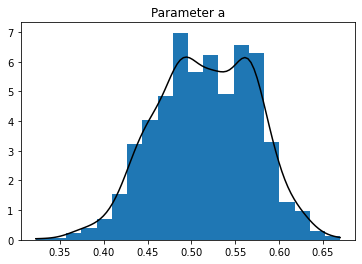

50% centred quantiles 0.1830726092867503 0.21684180213900253
90% centred quantiles 0.16401543851979067 0.2507956362939128


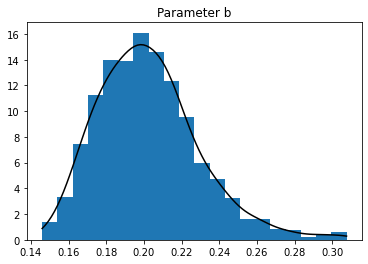

50% centred quantiles 28.667888953934156 56.69451464616277
90% centred quantiles 18.55123807817195 134.96420597150953


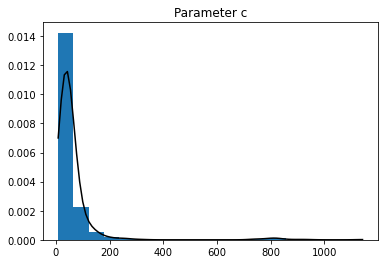

50% centred quantiles -0.025066704355390223 -0.017223325376504558
90% centred quantiles -0.03460948091763595 -0.013393924250021826


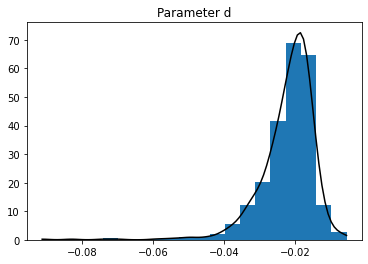

In [38]:
for P in Params.columns:
    
    
    Ps = Params[P]
    P_range = np.linspace(min(Ps), max(Ps),100)
    KDE = gaussian_kde(Ps)(P_range)
    
    print("50% centred quantiles", np.quantile(Ps, 0.25), 
          np.quantile(Ps, 0.75))
    print("90% centred quantiles", np.quantile(Ps, 0.05), 
          np.quantile(Ps, 0.95))
    plt.hist(Ps,bins=20, density= True)
    plt.plot(P_range, KDE, c="k")
    plt.title("Parameter "+str(P))
    plt.show()

### In more detail for c

In [39]:
np.quantile(Params["c"], 0.25), np.quantile(Params["c"], 0.75)

(28.667888953934156, 56.69451464616277)

[1.00000000e+00 1.25892541e+00 1.58489319e+00 1.99526231e+00
 2.51188643e+00 3.16227766e+00 3.98107171e+00 5.01187234e+00
 6.30957344e+00 7.94328235e+00 1.00000000e+01 1.25892541e+01
 1.58489319e+01 1.99526231e+01 2.51188643e+01 3.16227766e+01
 3.98107171e+01 5.01187234e+01 6.30957344e+01 7.94328235e+01
 1.00000000e+02 1.25892541e+02 1.58489319e+02 1.99526231e+02
 2.51188643e+02 3.16227766e+02 3.98107171e+02 5.01187234e+02
 6.30957344e+02 7.94328235e+02 1.00000000e+03 1.25892541e+03
 1.58489319e+03 1.99526231e+03 2.51188643e+03 3.16227766e+03
 3.98107171e+03 5.01187234e+03 6.30957344e+03 7.94328235e+03
 1.00000000e+04 1.25892541e+04 1.58489319e+04 1.99526231e+04
 2.51188643e+04 3.16227766e+04 3.98107171e+04 5.01187234e+04
 6.30957344e+04 7.94328235e+04]


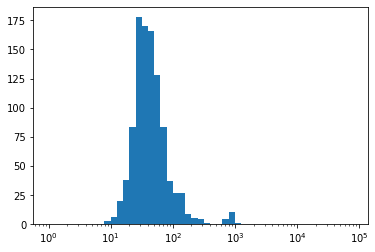

In [40]:
bins = 10**(np.arange(0,5,0.1))
print(bins)
plt.xscale('log')
plt.hist(Params["c"],bins=bins) 


plt.show()

### Analysis of the Curve

When does f(x) = y_est actually change? 
f(-infinity) = b and f(infinity) = a + b. We can now calculate the standard deviations of b and a+b via the bootstrap estimations and check when y_est exceeds b + sd(b) and reaches a+b - sd(a+b).

In [41]:
print(np.mean(Params["b"]), np.std(Params["b"]))
print(np.mean(Params["b"]+Params["a"]), np.std(Params["b"]+Params["a"]))

Thresh1 = np.mean(Params["b"]) + np.std(Params["b"])
Thresh2 = np.mean(Params["b"]+Params["a"]) - np.std(Params["b"]+Params["a"])
print(Thresh1, Thresh2)

def f1(x):
    # first threshold
    return(f(x, P0[0], P0[1], P0[2], P0[3])-Thresh1)

T1 = opt.root(f1, -0.5)

def f2(x):
    # second threshold
    return(f(x, P0[0], P0[1], P0[2], P0[3])-Thresh2)

T2 = opt.root(f2, 0.5)

0.2022795314509884 0.026941539403107038
0.7180057914609287 0.04117348155877073
0.22922107085409543 0.6768323099021579


C:\Users\Tobias\AppData\Local\Temp/ipykernel_10400/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


In [42]:
Timeframe = (T2["x"] -T1["x"])[0]
t_2, t_1 = T2["x"], T1["x"]
# scale this back to original time
print("Most of the cultural evolution takes place in a time interval of ", np.round(T*Timeframe), "years.")

Most of the cultural evolution takes place in a time interval of  1936.0 years.


## Bootstrapping the Time Interval

Now we can repeat this task, but 

-> Calculate the time thresholds T1/T2 for every single Bootstrapped Data and therefore calculate a time interval with standard deviation

In [43]:
def fBT1(x):
    # first threshold for the Bootstrapping
    return(f(x, a_, b_, c_, d_)-Thresh1)

def fBT2(x):
    # second threshold for the Bootstrapping
    return(f(x, a_, b_, c_, d_)-Thresh2)


In [44]:
random.seed(1234)
nBT = 1000 # how many Bootstraps
Successes = 0

Params2 = pd.DataFrame(columns = ["a", "b", "c", "d"]) # df of the parameters

for i in range(nBT):
    
    # Select the random NGAs
    NGA_selection = random.choices(NGA_list,k=len(NGA_list))
    Data_Bootstrap = pd.DataFrame(columns = Cutout_DF.columns)

    for n in NGA_selection: # combine them to a data frame
        Data_Bootstrap = pd.concat([Data_Bootstrap, Cutout_DF[Cutout_DF["NGA"]==n]])
    
    
    X, y = Data_Bootstrap["RelTime"].to_numpy(), Data_Bootstrap["SPC1"].to_numpy()

    X = np.array(list(X)) # for some reason, this transformation is necessary
    X = X/T # normalisation of the data
    (a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, P0) # p0: Initial guess = Full Estimation
                                                     # Otherwise: direction can reverse with c<0
    
    # Time Intervals
    T1 = opt.root(fBT1, t_1)
    T2 = opt.root(fBT2, t_2)
    
    # only add results, if opt.root is successful:
    if T1["success"] and T2["success"]:
        Successes += 1
        Params2 = pd.concat([Params2,
                       pd.DataFrame(data={"a":[a_], "b":[b_], "c":[c_], "d":[d_], "T1":T1["x"], "T2":T2["x"]})])    
        print(a_, b_, c_, d_, T1, T2)
        print("-----------------")


0.48032161379389093 0.20808036149282091 69.61832778117886 -0.017457196393967492     fjac: array([[-1.]])
     fun: array([6.9388939e-16])
 message: 'The solution converged.'
    nfev: 33
     qtf: array([1.40903372e-10])
       r: array([-1.4069954])
  status: 1
 success: True
       x: array([-0.06167319])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 22
     qtf: array([2.01927364e-12])
       r: array([-0.78605885])
  status: 1
 success: True
       x: array([0.03571396])

C:\Users\Tobias\AppData\Local\Temp/ipykernel_10400/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b



-----------------
0.5025524891355384 0.2008918085433569 68.9169957849351 -0.020328036681086143     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([1.01224584e-13])
       r: array([-1.84231131])
  status: 1
 success: True
       x: array([-0.06121465])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 22
     qtf: array([-5.70654635e-12])
       r: array([-1.7369014])
  status: 1
 success: True
       x: array([0.02151841])
-----------------
0.5839988682038527 0.1938120156875036 28.02268161695643 -0.014554465999604626     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([1.48769885e-14])
       r: array([-0.93209413])
  status: 1
 success: True
       x: array([-0.11234609])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([4.60742555e-14])
       r: array([-2.34

0.5086306435152171 0.193088325021906 55.970387267617745 -0.023883538466110438     fjac: array([[-1.]])
     fun: array([-1.60982339e-15])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([2.84052448e-10])
       r: array([-1.87870731])
  status: 1
 success: True
       x: array([-0.06981557])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([1.23488997e-11])
       r: array([-1.32476068])
  status: 1
 success: True
       x: array([0.02913064])
-----------------
0.5403819884952663 0.20257843342507145 22.61075308665135 -0.035296661486575814     fjac: array([[-1.]])
     fun: array([5.55111512e-17])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([3.53310436e-11])
       r: array([-0.57270809])
  status: 1
 success: True
       x: array([-0.16617259])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([8.92234

0.6232700273170257 0.18044454200303847 32.54980226639587 -0.011438835392394115     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([2.10886864e-13])
       r: array([-1.46341716])
  status: 1
 success: True
       x: array([-0.08720702])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([6.56441568e-11])
       r: array([-3.28922534])
  status: 1
 success: True
       x: array([0.03046919])
-----------------
0.6082861201951885 0.16459321451106262 31.146643578328643 -0.019633813195237236     fjac: array([[-1.]])
     fun: array([5.55111512e-17])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([6.69158062e-11])
       r: array([-1.79907168])
  status: 1
 success: True
       x: array([-0.08800957])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([2.54241073e-14])

0.4600919939665088 0.22719380325728325 92.39434497384394 -0.015013783098195708     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 26
     qtf: array([-8.35442826e-15])
       r: array([-0.18648273])
  status: 1
 success: True
       x: array([-0.07367886])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([-2.02038386e-12])
       r: array([-0.94389937])
  status: 1
 success: True
       x: array([0.02569767])
-----------------
0.5601969366090948 0.20076304903190356 17.814807059842302 -0.02897052779079955     fjac: array([[-1.]])
     fun: array([8.32667268e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([1.65043174e-10])
       r: array([-0.48121746])
  status: 1
 success: True
       x: array([-0.19331261])     fjac: array([[-1.]])
     fun: array([2.66453526e-15])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([5.14079113e-10])
       r: arr

0.5379134861277284 0.1855463586987505 25.755484553583795 -0.027158032308413755     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-1.33537625e-12])
       r: array([-1.03353233])
  status: 1
 success: True
       x: array([-0.12136125])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-2.15825136e-11])
       r: array([-1.09681573])
  status: 1
 success: True
       x: array([0.0642724])
-----------------
0.5013815232141219 0.2130089393188204 29.732591915627196 -0.024069234586053503     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 15
     qtf: array([1.9095836e-14])
       r: array([-0.46644235])
  status: 1
 success: True
       x: array([-0.13837943])     fjac: array([[-1.]])
     fun: array([1.33226763e-15])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-2.51634491e-10])
       r: ar

0.5436484653012174 0.18323678398101106 34.26894314720516 -0.02878216988167309     fjac: array([[-1.]])
     fun: array([-5.38458167e-15])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([6.35074937e-10])
       r: array([-1.44255391])
  status: 1
 success: True
       x: array([-0.09828025])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-7.50510765e-14])
       r: array([-1.55733965])
  status: 1
 success: True
       x: array([0.03800236])
-----------------
0.5914259415008516 0.17874538926760541 26.264938869896262 -0.011143063922812805     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([5.45365142e-11])
       r: array([-1.21259225])
  status: 1
 success: True
       x: array([-0.10144732])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-1.02140518e-13])

0.49510275522725794 0.20791872071547482 37.0238154072382 -0.02357153649206141     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([1.51337276e-12])
       r: array([-0.75476008])
  status: 1
 success: True
       x: array([-0.1073546])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([1.08801856e-14])
       r: array([-0.91833331])
  status: 1
 success: True
       x: array([0.05435324])
-----------------
0.687032993343156 0.21630660835078644 11.01804721561595 -0.007899214142826995     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-5.25293697e-12])
       r: array([-0.13961757])
  status: 1
 success: True
       x: array([-0.36686102])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.42219569e-13])
       r: array([-1.67287345

0.5741152702731775 0.18770338829293837 26.631977514632826 -0.02062964178681519     fjac: array([[-1.]])
     fun: array([5.55111512e-17])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([4.53886373e-11])
       r: array([-1.02573683])
  status: 1
 success: True
       x: array([-0.11644103])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-1.36557432e-14])
       r: array([-1.92830984])
  status: 1
 success: True
       x: array([0.04508592])
-----------------
0.4871148825470948 0.19948617413869746 44.88288834871433 -0.02301689001369909     fjac: array([[-1.]])
     fun: array([-1.77635684e-15])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([2.7821731e-10])
       r: array([-1.25312901])
  status: 1
 success: True
       x: array([-0.083913])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([3.885780

0.5431188815369954 0.20174289487564423 36.15333145147975 -0.02020137025082376     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([2.6811886e-14])
       r: array([-0.94316685])
  status: 1
 success: True
       x: array([-0.1013009])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([-1.81932247e-12])
       r: array([-2.15142278])
  status: 1
 success: True
       x: array([0.0335575])
-----------------
0.5124569951910491 0.19318775343669173 23.07209888624914 -0.034369660888792015     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([5.40296696e-11])
       r: array([-0.7729086])
  status: 1
 success: True
       x: array([-0.14627381])     fjac: array([[-1.]])
     fun: array([2.22044605e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-8.01880784e-11])
   

0.5204469922317513 0.2219612791369484 37.70418911702156 -0.01488465234062618     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([2.48029375e-12])
       r: array([-0.26990658])
  status: 1
 success: True
       x: array([-0.12782408])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([1.46486157e-11])
       r: array([-2.16095509])
  status: 1
 success: True
       x: array([0.03648377])
-----------------
0.5727528749049305 0.20209107899100415 16.924069238621623 -0.025562020476488305     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([1.84630089e-13])
       r: array([-0.43740095])
  status: 1
 success: True
       x: array([-0.20290047])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-2.19169127e-12])
       r: array

0.557515418418747 0.18198227649705762 19.2542111767254 -0.03295933520746962     fjac: array([[-1.]])
     fun: array([-4.99600361e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([1.50923885e-10])
       r: array([-0.83248183])
  status: 1
 success: True
       x: array([-0.15655502])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-6.28386232e-13])
       r: array([-1.07095249])
  status: 1
 success: True
       x: array([0.07436501])
-----------------
0.5149135550934935 0.1921241915099035 36.268179729035694 -0.025167522215555085     fjac: array([[-1.]])
     fun: array([-1.38777878e-16])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([6.19551632e-11])
       r: array([-1.2485073])
  status: 1
 success: True
       x: array([-0.09563409])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([4.3298698e-15])
    

0.5124566241029862 0.19480467027458798 65.1940537599001 -0.014716061232103981     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([2.22155627e-13])
       r: array([-2.09305543])
  status: 1
 success: True
       x: array([-0.05507498])     fjac: array([[-1.]])
     fun: array([3.33066907e-16])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([-9.60980184e-11])
       r: array([-1.86600032])
  status: 1
 success: True
       x: array([0.02765906])
-----------------
0.5868685249093573 0.1762453756859815 42.674142784652076 -0.009855075564173848     fjac: array([[-1.]])
     fun: array([-4.10782519e-15])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([5.77885434e-10])
       r: array([-2.0566378])
  status: 1
 success: True
       x: array([-0.0639947])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([-3.88578059e-13])
       r: arra

       x: array([-0.12673254])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([-1.49880108e-14])
       r: array([-2.82530713])
  status: 1
 success: True
       x: array([0.02289855])
-----------------
0.5256324476516283 0.19047337890245608 45.3564164796003 -0.01751913163190453     fjac: array([[-1.]])
     fun: array([-3.44169138e-15])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([-4.25211782e-10])
       r: array([-1.62788995])
  status: 1
 success: True
       x: array([-0.07332064])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([-3.4522385e-12])
       r: array([-1.64821328])
  status: 1
 success: True
       x: array([0.03796136])
-----------------
0.4946065467055044 0.20828249429186607 37.867994277242666 -0.026925908552671733     fjac: array([[-1.]])
     fun: array([-4.49640325e-15])
 message: 'The solut

0.5693239620681684 0.17472591627065243 28.383268700393707 -0.034315349955444566     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([7.18314297e-14])
       r: array([-1.39869706])
  status: 1
 success: True
       x: array([-0.1134367])     fjac: array([[-1.]])
     fun: array([1.88737914e-15])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-3.87084476e-10])
       r: array([-1.68261045])
  status: 1
 success: True
       x: array([0.03653193])
-----------------
0.5372535544846461 0.1691652852283537 40.70062943844021 -0.026515058902055296     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([6.1986527e-12])
       r: array([-2.17107713])
  status: 1
 success: True
       x: array([-0.07743951])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-1.56541446e-14])
       r: array([-1.137875

0.5103684685681562 0.1774595439134188 31.85369480915864 -0.022808443596952062     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([8.17679258e-13])
       r: array([-1.48157498])
  status: 1
 success: True
       x: array([-0.09129489])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-2.39930298e-12])
       r: array([-0.34270742])
  status: 1
 success: True
       x: array([0.09698451])
-----------------
0.6133213808412663 0.16974218197488491 33.173581182287855 -0.012434342564556023     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([1.10542131e-12])
       r: array([-1.78177734])
  status: 1
 success: True
       x: array([-0.07969446])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([-3.62520014e-11])

0.5170003811694598 0.18950768968746032 44.17711786529455 -0.015342905830519093     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([6.38178399e-12])
       r: array([-1.61965585])
  status: 1
 success: True
       x: array([-0.07162611])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([8.00470801e-14])
       r: array([-1.23573889])
  status: 1
 success: True
       x: array([0.04800663])
-----------------
0.5111599133853965 0.20252992048609014 31.514462752528114 -0.018629876461002965     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 14
     qtf: array([5.93247673e-13])
       r: array([-0.79723482])
  status: 1
 success: True
       x: array([-0.11061053])     fjac: array([[-1.]])
     fun: array([3.99680289e-15])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-4.83138529e-10])
       r: array([-1.0777

0.46374456996843794 0.2146899856401933 66.54116352121478 -0.017817154265824198     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 35
     qtf: array([1.54307123e-12])
       r: array([-0.93661735])
  status: 1
 success: True
       x: array([-0.06938235])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([-1.05090381e-11])
       r: array([-0.10624751])
  status: 1
 success: True
       x: array([0.0673101])
-----------------
0.5211940288832517 0.18092311955448911 49.948848484373634 -0.01684666445576655     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([1.2010809e-11])
       r: array([-2.18887098])
  status: 1
 success: True
       x: array([-0.06252312])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([-2.42250664e-13])
       r: array([-1.2016789])
  status

0.6131103078981682 0.16086327826780206 35.64197129224249 -0.012232213429221908     fjac: array([[-1.]])
     fun: array([5.55111512e-17])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([4.61297667e-14])
       r: array([-2.16476304])
  status: 1
 success: True
       x: array([-0.07046625])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([-6.89948099e-12])
       r: array([-2.91373737])
  status: 1
 success: True
       x: array([0.0346193])
-----------------
0.49695960647114257 0.19268471755825264 26.546320180350854 -0.03384100086755925     fjac: array([[-1.]])
     fun: array([-5.55111512e-17])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([2.75390544e-11])
       r: array([-0.89859974])
  status: 1
 success: True
       x: array([-0.12929071])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-3.09197112e-13])

0.4958589615823578 0.19128165402710814 42.30375111400902 -0.02775055683562573     fjac: array([[-1.]])
     fun: array([-4.71844785e-16])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([1.32923894e-10])
       r: array([-1.48218386])
  status: 1
 success: True
       x: array([-0.0866272])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([1.34336986e-14])
       r: array([-0.42701448])
  status: 1
 success: True
       x: array([0.06331309])
-----------------
0.6321144273313936 0.16686140386848408 28.38153876327988 -0.012906512693668631     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([-1.23660249e-11])
       r: array([-1.59526085])
  status: 1
 success: True
       x: array([-0.09085462])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-2.1515012e-12])
       r: arr

       x: array([-0.0674111])     fjac: array([[-1.]])
     fun: array([3.33066907e-16])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([7.49799112e-11])
       r: array([-1.03410595])
  status: 1
 success: True
       x: array([0.03141359])
-----------------
0.5086811994350786 0.20795195631393762 35.267321666270604 -0.0198143897184376     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 14
     qtf: array([4.60659288e-13])
       r: array([-0.71874123])
  status: 1
 success: True
       x: array([-0.10861767])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 14
     qtf: array([-7.79087905e-12])
       r: array([-1.29384242])
  status: 1
 success: True
       x: array([0.05012173])
-----------------
0.5702498758384329 0.22878492193917369 14.254286053068592 -0.03799951054455765     fjac: array([[-1.]])
     fun: array([1.94289029e-16])
 message: 'The solution converged.'
    nfev: 14
 

0.5675769575268015 0.20377601488248387 32.66534225122328 -0.02215193070863185     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-7.99249555e-13])
       r: array([-0.79390902])
  status: 1
 success: True
       x: array([-0.11579821])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([-3.25184324e-13])
       r: array([-2.57336876])
  status: 1
 success: True
       x: array([0.0271479])
-----------------
0.5562969450821762 0.1826469166482462 33.77727581924857 -0.031709900315808975     fjac: array([[-1.]])
     fun: array([-4.71844785e-16])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([-1.38025147e-10])
       r: array([-1.44143635])
  status: 1
 success: True
       x: array([-0.10255106])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([-7.32747196e-15])
       r: ar

0.4958496677427415 0.212440274485953 45.73656890765452 -0.023481815169413514     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([3.23460703e-12])
       r: array([-0.74152159])
  status: 1
 success: True
       x: array([-0.09676255])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 22
     qtf: array([-3.35287353e-14])
       r: array([-1.3474863])
  status: 1
 success: True
       x: array([0.03537891])
-----------------
0.5648280798602399 0.1618698978869998 31.972227426332072 -0.026346393448427076     fjac: array([[-1.]])
     fun: array([-7.77156117e-16])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([-2.11253959e-10])
       r: array([-1.89658855])
  status: 1
 success: True
       x: array([-0.08888907])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-1.01418873e-12])
       r: arr

       x: array([-0.08236216])     fjac: array([[-1.]])
     fun: array([7.77156117e-16])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([1.42088896e-10])
       r: array([-1.07710987])
  status: 1
 success: True
       x: array([0.05721233])
-----------------
0.5387489652672882 0.19560957322371805 41.293415804481555 -0.020288611090923083     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([4.22994972e-14])
       r: array([-1.30134307])
  status: 1
 success: True
       x: array([-0.0859156])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([-8.6264329e-14])
       r: array([-2.12180963])
  status: 1
 success: True
       x: array([0.03115032])
-----------------
0.5866610815111872 0.20932080807725392 21.344776155778735 -0.020871015042888384     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12

0.6177863061442216 0.18586425018317324 33.04776765232321 -0.01072118774351918     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([3.95253275e-12])
       r: array([-1.33228815])
  status: 1
 success: True
       x: array([-0.08890841])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([1.93822736e-12])
       r: array([-3.33072504])
  status: 1
 success: True
       x: array([0.03023844])
-----------------
0.534801389975871 0.1980268904431259 15.640096496655685 -0.05526114674605773     fjac: array([[-1.]])
     fun: array([8.57647287e-15])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([5.83630227e-10])
       r: array([-0.45941593])
  status: 1
 success: True
       x: array([-0.23310948])     fjac: array([[-1.]])
     fun: array([1.66533454e-15])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-3.46918161e-10])
     

0.49656627596260255 0.19309421794328366 31.439192103230287 -0.020251585669178198     fjac: array([[-1.]])
     fun: array([6.74460487e-15])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([6.78786582e-10])
       r: array([-1.05315542])
  status: 1
 success: True
       x: array([-0.10120611])     fjac: array([[-1.]])
     fun: array([2.22044605e-16])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([4.43028947e-11])
       r: array([-0.39288715])
  status: 1
 success: True
       x: array([0.09520618])
-----------------
0.4944578231669569 0.22003085820094706 61.62971298433815 -0.018853034960168026     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 24
     qtf: array([3.76393361e-13])
       r: array([-0.55586285])
  status: 1
 success: True
       x: array([-0.08321422])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([-4.57733851e-12])
       r: a

0.5435241853857756 0.1946599436256309 36.32848807952299 -0.022898316744405872     fjac: array([[-1.]])
     fun: array([-1.55431223e-15])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([2.64421762e-10])
       r: array([-1.17572342])
  status: 1
 success: True
       x: array([-0.09693514])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([-2.81541457e-12])
       r: array([-1.97723415])
  status: 1
 success: True
       x: array([0.03385265])
-----------------
0.488823272336901 0.21406859058331973 53.48588345089343 -0.019784128577865684     fjac: array([[-1.]])
     fun: array([-8.32667268e-17])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([-3.05760417e-11])
       r: array([-0.78531947])
  status: 1
 success: True
       x: array([-0.08414407])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([-9.21596133e-13])

0.6552301555036815 0.15140095613407145 34.21867963525463 -0.012159376129521109     fjac: array([[-1.]])
     fun: array([-7.21644966e-16])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([2.41739684e-10])
       r: array([-2.34664246])
  status: 1
 success: True
       x: array([-0.07072834])     fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 15
     qtf: array([-1.73215775e-10])
       r: array([-3.56168388])
  status: 1
 success: True
       x: array([0.02870234])
-----------------
0.5953158121425874 0.17993711729119866 29.560761914717673 -0.011824317837290595     fjac: array([[-1.]])
     fun: array([-5.55111512e-17])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([-2.68373379e-11])
       r: array([-1.33626069])
  status: 1
 success: True
       x: array([-0.09318483])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-2.47035725e-

0.607991837666279 0.1603642246581351 30.856047799531794 -0.010916992861219284     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([2.44251286e-11])
       r: array([-1.88402568])
  status: 1
 success: True
       x: array([-0.07761174])     fjac: array([[-1.]])
     fun: array([-9.99200722e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-3.04672176e-10])
       r: array([-2.39893516])
  status: 1
 success: True
       x: array([0.04516326])
-----------------
0.5777589729067037 0.18347748799825267 30.091894367933715 -0.01818414232395654     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([8.87789842e-13])
       r: array([-1.26752677])
  status: 1
 success: True
       x: array([-0.09972174])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-8.16469115e-12])
       r: a

0.5991781807817312 0.15715722773500818 23.17610428190329 -0.03829802375854129     fjac: array([[-1.]])
     fun: array([-5.55111512e-17])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([4.25659508e-13])
       r: array([-1.46928728])
  status: 1
 success: True
       x: array([-0.1241565])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-4.28546088e-14])
       r: array([-1.59808691])
  status: 1
 success: True
       x: array([0.04270816])
-----------------
0.5151496373310691 0.18736364957444687 65.10640527267586 -0.02185750442792721     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([3.42650908e-12])
       r: array([-2.50375771])
  status: 1
 success: True
       x: array([-0.05911104])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 22
     qtf: array([-2.90656388e-13])
 

0.550576433644699 0.20785604557758783 22.524736034435303 -0.026898107147781253     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([9.18007337e-12])
       r: array([-0.46256657])
  status: 1
 success: True
       x: array([-0.1693918])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-2.66350275e-11])
       r: array([-1.56561269])
  status: 1
 success: True
       x: array([0.05073747])
-----------------
0.4620424858997358 0.2261382635065158 59.93038308658643 -0.019797600572134068     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([-3.28517769e-12])
       r: array([-0.18352076])
  status: 1
 success: True
       x: array([-0.10327983])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([-2.24922303e-11])
       r: array([-0.66341338])
  stat

0.5241676216214759 0.16155697114206025 49.55461817347758 -0.017262765234888053     fjac: array([[-1.]])
     fun: array([-9.99200722e-16])
 message: 'The solution converged.'
    nfev: 22
     qtf: array([-2.52492666e-10])
       r: array([-2.92021402])
  status: 1
 success: True
       x: array([-0.05578674])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([1.64974701e-11])
       r: array([-0.433177])
  status: 1
 success: True
       x: array([0.0646573])
-----------------
0.5892181381782824 0.20708594305247194 24.819918507872405 -0.021405228039020337     fjac: array([[-1.]])
     fun: array([-7.77156117e-16])
 message: 'The solution converged.'
    nfev: 15
     qtf: array([1.50296497e-10])
       r: array([-0.52875589])
  status: 1
 success: True
       x: array([-0.15208011])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([3.885

0.5393093913828139 0.1801343323277504 44.74516123582375 -0.02431664544640602     fjac: array([[-1.]])
     fun: array([2.49800181e-16])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([9.68551073e-11])
       r: array([-1.99647807])
  status: 1
 success: True
       x: array([-0.07574725])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([-1.24859012e-11])
       r: array([-1.75600899])
  status: 1
 success: True
       x: array([0.03056884])
-----------------
0.5062455560516814 0.18683055902085235 46.76748889092913 -0.02734012817828163     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([-6.62386812e-13])
       r: array([-1.81649293])
  status: 1
 success: True
       x: array([-0.07850062])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-4.70945505e-12])
       r: arra

       x: array([0.06089078])
-----------------
0.49839311717416446 0.20971435302491634 31.18370126367717 -0.02441671143184602     fjac: array([[-1.]])
     fun: array([-5.82867088e-16])
 message: 'The solution converged.'
    nfev: 14
     qtf: array([-1.08301978e-10])
       r: array([-0.58448042])
  status: 1
 success: True
       x: array([-0.12705701])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([9.64450741e-13])
       r: array([-0.91407461])
  status: 1
 success: True
       x: array([0.06228748])
-----------------
0.48682190272031567 0.21146890778196897 29.881676116055992 -0.025666240106798206     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 15
     qtf: array([1.65725766e-11])
       r: array([-0.51112001])
  status: 1
 success: True
       x: array([-0.13523988])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev:

0.585057475255883 0.18188288607867298 42.01329750503109 -0.014979055100677872     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([4.41618964e-12])
       r: array([-1.827912])
  status: 1
 success: True
       x: array([-0.07281835])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([-1.08135723e-13])
       r: array([-3.20267349])
  status: 1
 success: True
       x: array([0.02556635])
-----------------
0.47217652490771095 0.20611720586464324 58.56873109627969 -0.02142966517694408     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([2.59955946e-12])
       r: array([-1.28695238])
  status: 1
 success: True
       x: array([-0.07209125])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([-4.14202006e-12])
       r: array([-0.08532892])
  status

0.4813811426154373 0.21610488840808073 46.03657489550533 -0.021404808840299064     fjac: array([[-1.]])
     fun: array([5.82867088e-16])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([9.84746451e-11])
       r: array([-0.58736817])
  status: 1
 success: True
       x: array([-0.09906453])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-8.89288643e-14])
       r: array([-0.91003121])
  status: 1
 success: True
       x: array([0.04603963])
-----------------
0.5504678168397367 0.19398005223431866 20.426768812627106 -0.03389825102512877     fjac: array([[-1.]])
     fun: array([-8.32667268e-17])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([4.05406542e-11])
       r: array([-0.67377581])
  status: 1
 success: True
       x: array([-0.16521596])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-1.07247544e-13])

0.5070577925023313 0.21698403818668596 38.59540867325553 -0.024068976084949716     fjac: array([[-1.]])
     fun: array([-5.55111512e-17])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-2.19749774e-11])
       r: array([-0.46089404])
  status: 1
 success: True
       x: array([-0.11992827])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([3.61877195e-12])
       r: array([-1.65242659])
  status: 1
 success: True
       x: array([0.03490957])
-----------------
0.5344510374509512 0.19647233770411388 56.81472326998247 -0.01432706103557494     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([7.24031946e-13])
       r: array([-1.74660074])
  status: 1
 success: True
       x: array([-0.0623629])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([-3.01314529e-13])
       r: arr

0.603925663194721 0.18471903768105807 27.12656195186554 -0.01227827410139098     fjac: array([[-1.]])
     fun: array([-3.33066907e-16])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-1.08376308e-10])
       r: array([-1.11822845])
  status: 1
 success: True
       x: array([-0.10559538])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([1.85851334e-12])
       r: array([-2.47153194])
  status: 1
 success: True
       x: array([0.04235034])
-----------------
0.5210388357862704 0.1820439335645255 46.88702708492857 -0.023359375355344086     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([5.91443561e-13])
       r: array([-2.01171216])
  status: 1
 success: True
       x: array([-0.07256288])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([-9.48130463e-14])
       r: arra

0.5297773053980408 0.19481273145688827 42.730617784664375 -0.015571804460539088     fjac: array([[-1.]])
     fun: array([-3.88578059e-15])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([4.73298761e-10])
       r: array([-1.37480754])
  status: 1
 success: True
       x: array([-0.07798616])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([-1.05904174e-12])
       r: array([-1.85675336])
  status: 1
 success: True
       x: array([0.03853094])
-----------------
0.5291450734519436 0.19698204411230877 26.989275551039135 -0.016754617314094084     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([8.64974758e-13])
       r: array([-0.81709537])
  status: 1
 success: True
       x: array([-0.11809944])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([7.66053887e-15])
       r:

0.4967787590482991 0.19158024513507133 33.172447475587575 -0.03161395390439114     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 14
     qtf: array([1.72084569e-14])
       r: array([-1.15402927])
  status: 1
 success: True
       x: array([-0.10701573])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([1.2101431e-14])
       r: array([-0.37349655])
  status: 1
 success: True
       x: array([0.0811303])
-----------------
0.4832059883478439 0.19898085667121337 29.697219201615027 -0.03740010292036495     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([2.15383267e-14])
       r: array([-0.84184812])
  status: 1
 success: True
       x: array([-0.12854143])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([6.84674539e-12])
       r: array

0.5215325191560634 0.16502833395564143 40.191201377062136 -0.025672758872295403     fjac: array([[-1.]])
     fun: array([-3.33066907e-16])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([1.39867895e-10])
       r: array([-2.2624321])
  status: 1
 success: True
       x: array([-0.07452764])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([-1.08801856e-14])
       r: array([-0.38370824])
  status: 1
 success: True
       x: array([0.07292786])
-----------------
0.5237121230358609 0.18673044159201704 40.24824526993912 -0.027857946663677583     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([1.47742929e-13])
       r: array([-1.57142076])
  status: 1
 success: True
       x: array([-0.08815981])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([-2.52020627e-14])
       r: a

0.4907006953988703 0.21810064285244096 60.43225442872365 -0.017654605408127858     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 34
     qtf: array([2.2565283e-14])
       r: array([-0.65680268])
  status: 1
 success: True
       x: array([-0.07994134])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([-2.41251463e-13])
       r: array([-1.80609357])
  status: 1
 success: True
       x: array([0.02642281])
-----------------
0.5614416177988276 0.21125992290991907 18.66141824420634 -0.029164749202213968     fjac: array([[-1.]])
     fun: array([-1.91513472e-15])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.20759494e-10])
       r: array([-0.32446051])
  status: 1
 success: True
       x: array([-0.21188306])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-3.20554694e-12])
       r: arr

0.5667529755291503 0.20055561827456392 19.010999521006315 -0.032569786609773985     fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([7.00974279e-11])
       r: array([-0.51739723])
  status: 1
 success: True
       x: array([-0.18681357])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-3.22963878e-13])
       r: array([-1.44545722])
  status: 1
 success: True
       x: array([0.05479601])
-----------------
0.5429092982720666 0.1925536816815866 45.94371713700839 -0.015512791132597908     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([2.31203945e-14])
       r: array([-1.57085806])
  status: 1
 success: True
       x: array([-0.07265068])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([6.66253719e-11])

0.527610494258992 0.18779259632735912 61.90277421802922 -0.016989882281565057     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([1.29368738e-13])
       r: array([-2.36316748])
  status: 1
 success: True
       x: array([-0.05677186])     fjac: array([[-1.]])
     fun: array([1.22124533e-15])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([2.2339175e-10])
       r: array([-2.21307899])
  status: 1
 success: True
       x: array([0.02404138])
-----------------
0.566216436880469 0.21256275622099657 19.98639262228108 -0.02006726538610597     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-3.15025783e-14])
       r: array([-0.32314439])
  status: 1
 success: True
       x: array([-0.19499654])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-8.29925018e-12])
   

0.4897891266709702 0.19565527523685816 45.84917538808915 -0.024016749126190503     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([3.72563091e-13])
       r: array([-1.43349727])
  status: 1
 success: True
       x: array([-0.08093107])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([4.20774526e-12])
       r: array([-0.38791397])
  status: 1
 success: True
       x: array([0.06372895])
-----------------
0.5041682245634762 0.2039116513593124 55.05606821272226 -0.02359523316362312     fjac: array([[-1.]])
     fun: array([-3.05311332e-16])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([8.50217119e-11])
       r: array([-1.323491])
  status: 1
 success: True
       x: array([-0.0769995])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([-8.86068996e-13])
    

In [45]:
print(Successes)
print(Params2.round(2))

721
       a     b      c     d    T1    T2
0   0.48  0.21  69.62 -0.02 -0.06  0.04
0   0.50  0.20  68.92 -0.02 -0.06  0.02
0   0.58  0.19  28.02 -0.01 -0.11  0.04
0   0.50  0.19  49.12 -0.02 -0.07  0.06
0   0.54  0.21  27.15 -0.03 -0.14  0.04
..   ...   ...    ...   ...   ...   ...
0   0.50  0.21  37.86 -0.03 -0.11  0.05
0   0.54  0.19  20.46 -0.03 -0.16  0.08
0   0.52  0.22  44.33 -0.02 -0.10  0.03
0   0.52  0.21  42.75 -0.02 -0.09  0.03
0   0.50  0.19  47.83 -0.02 -0.07  0.07

[721 rows x 6 columns]


In [46]:
T2_scaled, T1_scaled = np.mean(Params2["T2"])*T, T*np.mean(Params2["T1"])

T1_start_scaled = T*np.mean(Params2["T1"]) - T*np.std(Params2["T1"])
T2_end_scaled = T*np.mean(Params2["T2"]) + T*np.std(Params2["T2"])

In [47]:
TimeframeBT = Params2["T2"]-Params2["T1"]
print(np.mean(TimeframeBT))

# times T for the transformation to years
print("Most of the cultural evolution takes place in a time interval of ", np.round(T*np.mean(TimeframeBT)),
      u"\u00B1",np.round(T*np.std(TimeframeBT)), "years.")

0.15687391949549223
Most of the cultural evolution takes place in a time interval of  784.0 ± 328.0 years.


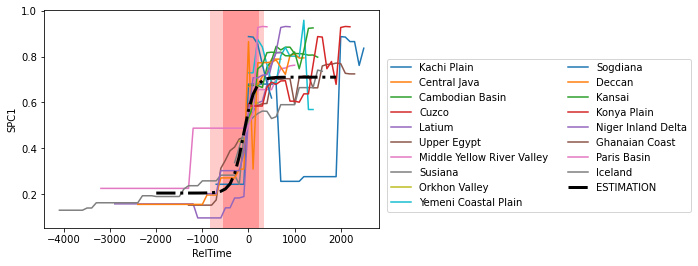

In [48]:
DF_Out_cutout = pd.DataFrame(columns=["NGA","RelTime","SPC1"])

for N in list(set(Cutout_DF["NGA"])):
    DF = Cutout_DF[Cutout_DF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    DF_Out_cutout = pd.concat((DF_Out_cutout, DF[["NGA", "RelTime", "SPC1"]]))
    #print(N)
    
plt.plot(TimeRange, New_Fit, "-.",label="ESTIMATION", c = "k", linewidth=3)
plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)
plt.ylabel("SPC1")
plt.xlabel("RelTime")
plt.axvspan(T1_scaled, T2_scaled, facecolor='r', alpha=0.4)
plt.axvspan(T2_scaled, T2_end_scaled, facecolor='r', alpha=0.2)
plt.axvspan(T1_start_scaled, T1_scaled, facecolor='r', alpha=0.2)
plt.savefig("SPC1_Time_Interval_Cutouts")
plt.show()

In [49]:
Cutout_CCDF.index = np.arange(0,len(Cutout_CCDF["NGA"]))
Cutout_CCDF.to_csv("Cutouts_CC_with_Reltime.csv")